we can just be careful to orthonomalize your basis, your singular basis has to be orthonormalize, you can use it to generate it, that can be the product of the basis. That is for the first part of the experiment. It would be interesting to apply those experiments, to some matrices, representatives of some problems, mechanical or chemical ones. If you know the, 
You can go there to find some use case. If you go to suite sparese Matrix collection. 
You can download , 2D,3D problem. which is AG  Monien airfolien problem

You can download it as matrix market format. 

import scipy as sp
A = sp.io.mmread('airfoil1.mtx')
when you do your numerical or experimentation,

we are doing it from Frobenius norm and Spectrum norm, and what would be interesting to compare it with truncated SVD, deterministic one
to be used as reference for, experiment. 
The storage part, also interesting, storage requirement. Different experiment you do. You have to be careful, when you do time experiment. 
Start with this part, 
1 and 2 of exercise. 
Preliminary Implement truncated SVD algo, to get reference approximation for given k target rank
Implement basic RSVD

You have error , theoretical 

it will be like a log graph

A - A approx vs k , RSVD, SVD , study it and compare it with P = 0, P=10, to play with different parameters


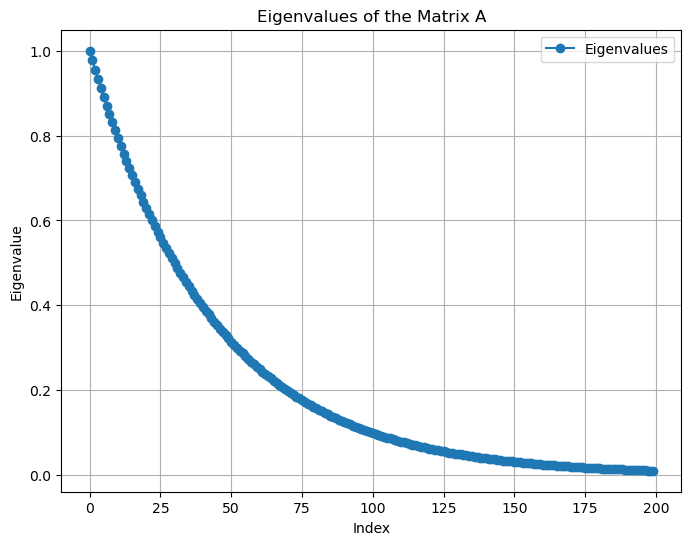

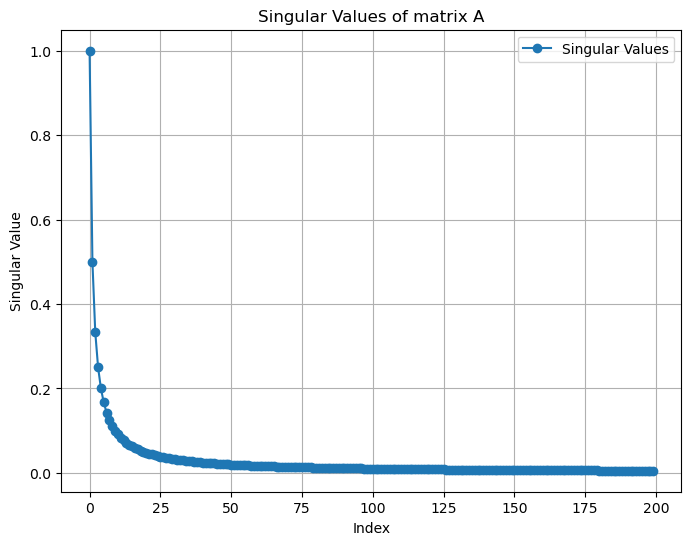

In [20]:
import numpy as np
import scipy.linalg as la

# Truncated SVD function
def truncated_svd(A, k):
    U, S, Vt = la.svd(A, full_matrices=False) #ensures that U and Vt are not padded with zeros, match the dimensions of A
    U_k = U[:, :k] # first k columns of U
    S_k = np.diag(S[:k]) # first k singular values, np.diag(S[:k]) converts the vector of singular values into a diagonal matrix.
    
    Vt_k = Vt[:k, :] # first k rows of Vt
    return U_k, S_k, Vt_k #returns the truncated matrices

In [8]:
# Basic RSVD algorithm
def rsvd(A, k, p, q=0):
    m, n = A.shape # A random matrix generated, 
    Omega = np.random.randn(n, k + p)
    Y = A @ Omega #matrix used to project A onto a lower-dimensional space
    
    # Power iteration
    for _ in range(q):
        Y = A @ (A.T @ Y) #power iteration to improve the accuracy of the approximation, process enhances the signal in the directions corresponding to the largest singular values
    
    Q, _ = la.qr(Y, mode='economic') #An orthogonal matrix obtained from the QR decomposition of Y, matrix represents an orthonormal basis for the range of Y, which approximates the range of A.
    B = Q.T @ A #This reduces the dimensionality of A while preserving its most important features.
    U_hat, S, Vt = la.svd(B, full_matrices=False) #: The SVD of the projected matrix B. U_hat contains the singular vectors of B, S contains the singular values, and Vt contains the right singular vectors.
    U = Q @ U_hat # approximation of the left singular vectors of A, obtained by transforming U_hat back to the original space using Q.
    return U[:, :k], np.diag(S[:k]), Vt[:k, :] #returns the truncated matrices, top k left singular vectors of A, A diagonal matrix containing the top k singular values, The top k right singular vectors

In [9]:
if __name__ == "__main__":
    # Synthesize a matrix with specific singular values distribution
    rng = np.random.default_rng()
    m, n = 200, 200
    r = min(m, n)
    eigenvals = np.logspace(0, -2, r)
    D = np.zeros((r, r))
    np.fill_diagonal(D, eigenvals)
    U, _ = la.qr(rng.standard_normal(size=(m, r)), mode='economic')
    V, _ = la.qr(rng.standard_normal(size=(n, r)), mode='economic')
    A = U @ D @ V.T

    # Truncated SVD
    k = 10
    U_k, S_k, Vt_k = truncated_svd(A, k)
    print("Truncated SVD results:")
    print("U_k shape:", U_k.shape)
    print("S_k shape:", S_k.shape)
    print("Vt_k shape:", Vt_k.shape)

    # Basic RSVD
    p = 5
    U_rsvd, S_rsvd, Vt_rsvd = rsvd(A, k, p)
    print("RSVD results:")
    print("U_rsvd shape:", U_rsvd.shape)
    print("S_rsvd shape:", S_rsvd.shape)
    print("Vt_rsvd shape:", Vt_rsvd.shape)

Truncated SVD results:
U_k shape: (200, 10)
S_k shape: (10, 10)
Vt_k shape: (10, 200)
RSVD results:
U_rsvd shape: (200, 10)
S_rsvd shape: (10, 10)
Vt_rsvd shape: (10, 200)


In [42]:
def rsvd_single_pass(A, k, p=5):
    m, n = A.shape
    l = k + p  # Target rank + oversampling
    
    # Step 1: Generate random test matrices
    Omega1 = np.random.randn(n, l)  # For column space
    Omega2 = np.random.randn(m, l)  # For row space
    
    # Step 2: Single pass through A to compute sample matrices
    Y = A @ Omega1     # Sample columns: m × l matrix
    Z = A.T @ Omega2   # Sample rows: n × l matrix
    
    # Step 3: Compute orthonormal bases 
    Q1, _ = la.qr(Y, mode='economic')  # Orthogonal basis for column space
    Q2, _ = la.qr(Z, mode='economic')  # Orthogonal basis for row space
    
    # Step 4: Approximate the core matrix without accessing A again
    # Key idea: Use Y and Z to approximate C = Q1^T @ A @ Q2
    # C ≈ (Q1^T @ Y) @ (Omega1^T @ Q2)
    approx_C = (Q1.T @ Y) @ (la.pinv(Omega1.T @ Q2))
    
    # Alternative approximation if first approach yields poor results:
    # approx_C = (la.pinv(Q1.T @ Omega2)) @ (Z.T @ Q2)
    
    # Step 5: SVD of the approximated core matrix
    Uc, sc, Vhc = la.svd(approx_C, full_matrices=False)
    
    # Step 6: Map back to original space
    U = Q1 @ Uc[:, :k]
    V = Q2 @ Vhc.T[:, :k]
    S = np.diag(sc[:k])  # Return as diagonal matrix to match existing code
    
    return U, S, V.T

In [43]:
# Variant 2: Multiple passes RSVD
def rsvd_multiple_passes(A, k, p, num_passes=2):
    m, n = A.shape
    Omega = np.random.randn(n, k + p)
    Y = A @ Omega
    
    for _ in range(num_passes):
        Y = A @ (A.T @ Y)
    
    Q, _ = la.qr(Y, mode='economic')
    B = Q.T @ A
    U_hat, S, Vt = la.svd(B, full_matrices=False)
    U = Q @ U_hat
    return U[:, :k], np.diag(S[:k]), Vt[:k, :]

In [12]:
import numpy as np
import scipy.io
import scipy.linalg as la

# Function to load matrices from MatrixMarket format
def load_matrix(file_path):
    return scipy.io.mmread(file_path).toarray()

# Load the airfoil1 matrix
file_path = '/Users/shubhankar/Documents/GitSpace/RNLA/hpc-ia-rnla-main/airfoil1/airfoil1.mtx'
A = load_matrix(file_path)
print(f"Loaded matrix shape: {A.shape}")

Loaded matrix shape: (4253, 4253)


In [ ]:

# Function to test RSVD implementations
def test_rsvd(A, k, p_values, q_values):
    U_k, S_k, Vt_k = truncated_svd(A, k)
    A_tsvd = U_k @ S_k @ Vt_k
    norm_tsvd = np.linalg.norm(A - A_tsvd, 'fro')
    print(f"Truncated SVD Frobenius norm difference: {norm_tsvd}")
    
    results = []
    
    for p in p_values:
        for q in q_values:
            U_rsvd, S_rsvd, Vt_rsvd = rsvd(A, k, p)
            A_rsvd = U_rsvd @ S_rsvd @ Vt_rsvd
            norm_rsvd = np.linalg.norm(A - A_rsvd, 'fro')
            print(f"RSVD (p={p}, q={q}) Frobenius norm difference: {norm_rsvd}")

            U_rsvd_single, S_rsvd_single, Vt_rsvd_single = rsvd_single_pass(A, k, p)
            A_rsvd_single = U_rsvd_single @ S_rsvd_single @ Vt_rsvd_single
            norm_rsvd_single = np.linalg.norm(A - A_rsvd_single, 'fro')
            print(f"Single pass RSVD (p={p}) Frobenius norm difference: {norm_rsvd_single}")

            U_rsvd_multi, S_rsvd_multi, Vt_rsvd_multi = rsvd_multiple_passes(A, k, p, q)
            A_rsvd_multi = U_rsvd_multi @ S_rsvd_multi @ Vt_rsvd_multi
            norm_rsvd_multi = np.linalg.norm(A - A_rsvd_multi, 'fro')
            print(f"Multiple passes RSVD (p={p}, q={q}) Frobenius norm difference: {norm_rsvd_multi}")

            results.append((p, q, norm_rsvd, norm_rsvd_single, norm_rsvd_multi))

    return results

if __name__ == "__main__":
    # Load the airfoil1 matrix
    file_path = '/Users/shubhankar/Documents/GitSpace/RNLA/hpc-ia-rnla-main/airfoil1/airfoil1.mtx'
    A = load_matrix(file_path)
    print(f"Loaded matrix shape: {A.shape}")

    # Parameters
    k = 10
    p_values = [5, 10, 20]
    q_values = [0, 1, 2]

    # Test the RSVD implementations on the airfoil1 matrix
    results = test_rsvd(A, k, p_values, q_values)

In [38]:

# Function to plot results
def plot_results(results):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    for p, q, norm_rsvd, norm_rsvd_single, norm_rsvd_multi in results:
        ax[0].scatter(p, norm_rsvd, label=f'q={q}')
        ax[1].scatter(p, norm_rsvd_single, label=f'q={q}')
        ax[2].scatter(p, norm_rsvd_multi, label=f'q={q}')

    ax[0].set_title('RSVD with Power Iteration')
    ax[0].set_xlabel('p')
    ax[0].set_ylabel('Frobenius Norm Difference')
    ax[0].legend()

    ax[1].set_title('Single Pass RSVD')
    ax[1].set_xlabel('p')
    ax[1].set_ylabel('Frobenius Norm Difference')
    ax[1].legend()

    ax[2].set_title('Multiple Passes RSVD')
    ax[2].set_xlabel('p')
    ax[2].set_ylabel('Frobenius Norm Difference')
    ax[2].legend()

    plt.show()


In [ ]:

if __name__ == "__main__":
    # Load the airfoil1 matrix
    file_path = 'airfoil1.mtx'
    A = load_matrix(file_path)
    print(f"Loaded matrix shape: {A.shape}")

    # Parameters
    k = 10
    p_values = [5, 10, 20]
    q_values = [0, 1, 2]

    # Test the RSVD implementations on the airfoil1 matrix
    results = test_rsvd(A, k, p_values, q_values)

    # Plot the results
    plot_results(results)

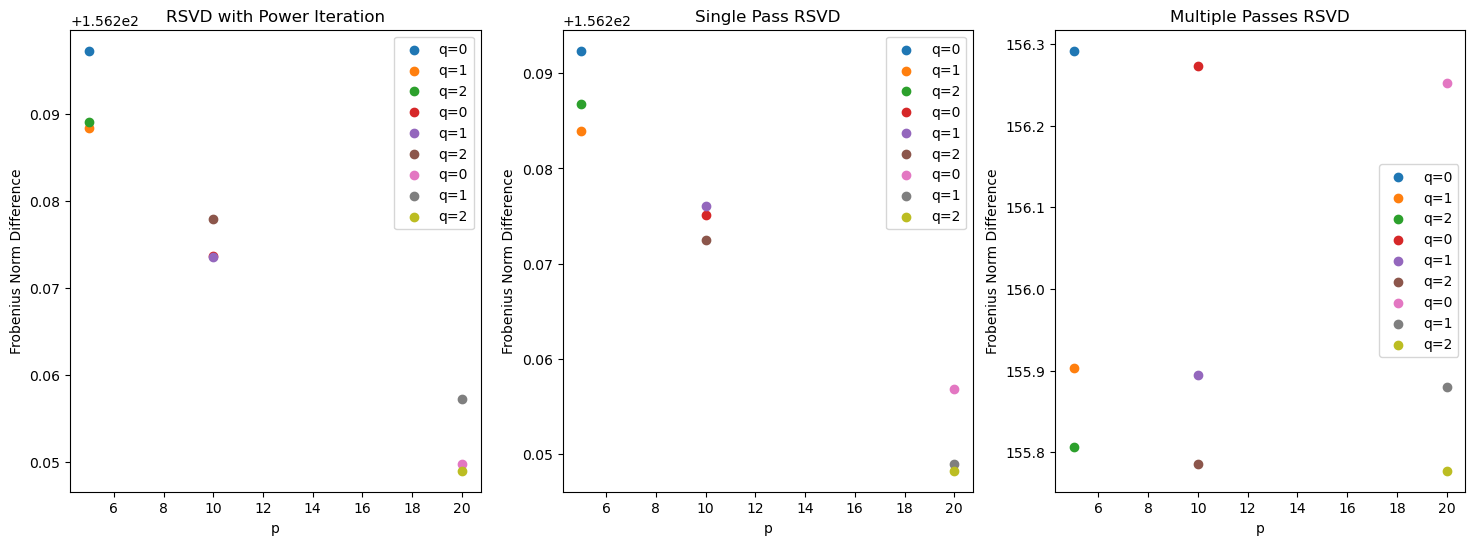

In [20]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    plot_results(results)

In [30]:
import numpy as np
import scipy.linalg as la

# Function to plot results
def plot_results2(results):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Group results by p and q for continuous lines
    for p in set(r[1] for r in results):
        for q in set(r[2] for r in results):
            k_vals = [r[0] for r in results if r[1] == p and r[2] == q]
            residuals_rsvd = [r[4] for r in results if r[1] == p and r[2] == q]
            residuals_rsvd_multi = [r[6] for r in results if len(r) > 6 and r[1] == p and r[2] == q]
            if k_vals and residuals_rsvd:
                ax[0].plot(k_vals, residuals_rsvd, label=f'p={p}, q={q}')
            if k_vals and residuals_rsvd_multi:
                ax[2].plot(k_vals, residuals_rsvd_multi, label=f'p={p}, q={q}')

    for p in set(r[1] for r in results):
        k_vals = [r[0] for r in results if r[1] == p]
        residuals_rsvd_single = [r[5] for r in results if len(r) > 5 and r[1] == p]
        if k_vals and residuals_rsvd_single:
            ax[1].plot(k_vals, residuals_rsvd_single, label=f'p={p}')

    ax[0].set_title('RSVD with Power Iteration')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Residual (Frobenius Norm Difference)')
    ax[0].legend()

    ax[1].set_title('Single Pass RSVD')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Residual (Frobenius Norm Difference)')
    ax[1].legend()

    ax[2].set_title('Multiple Passes RSVD')
    ax[2].set_xlabel('k')
    ax[2].set_ylabel('Residual (Frobenius Norm Difference)')
    ax[2].legend()

    plt.show()

/var/folders/7t/xg79cq59259fd0043vdyn01h0000gp/T/ipykernel_1058/890739954.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()
/var/folders/7t/xg79cq59259fd0043vdyn01h0000gp/T/ipykernel_1058/890739954.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()


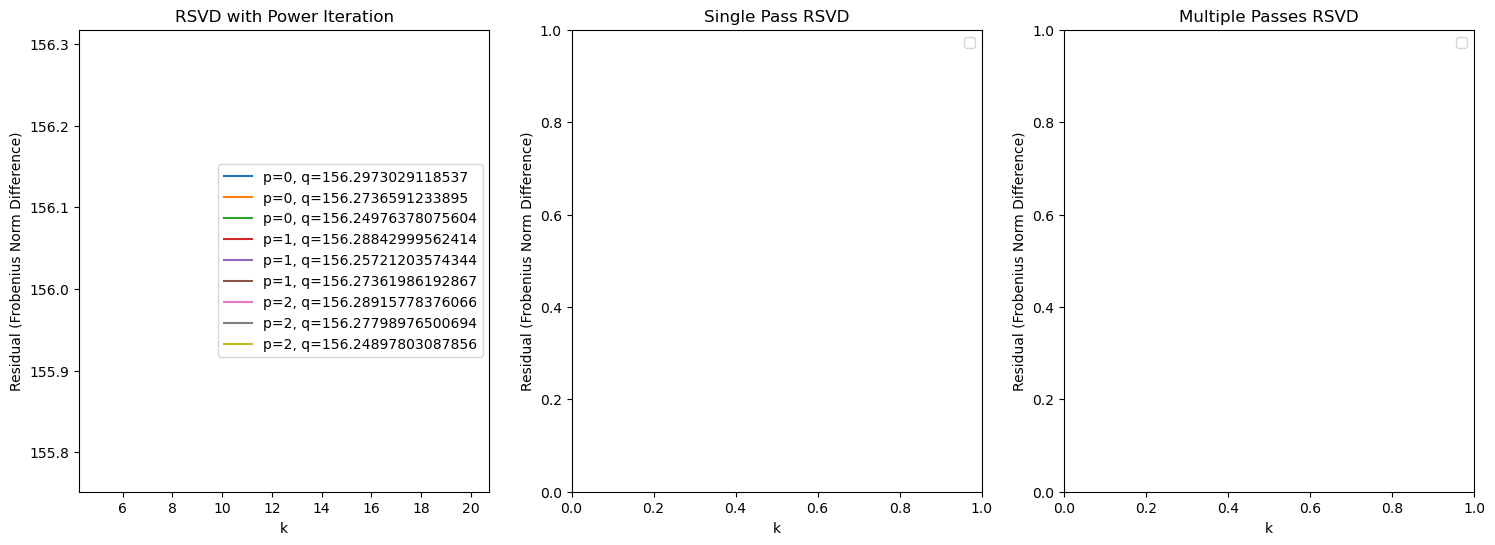

In [31]:
import matplotlib.pyplot as plt

if __name__ == "__main__":

    plot_results2(results)

In [44]:
import numpy as np
import scipy.linalg as la


# Test the RSVD algorithms on synthetic data
def test_synthetic_matrix():
    # Synthesize a matrix with specific singular values distribution
    rng = np.random.default_rng(42)  # Set seed for reproducibility
    m, n = 200, 200
    r = min(m, n)
    eigenvals = np.logspace(0, -2, r)  # Exponential decay of singular values
    D = np.zeros((r, r))
    np.fill_diagonal(D, eigenvals)
    U, _ = la.qr(rng.standard_normal(size=(m, r)), mode='economic')
    V, _ = la.qr(rng.standard_normal(size=(n, r)), mode='economic')
    A = U @ D @ V.T
    
    # Parameters to test
    k_values = [5, 10, 20, 30, 40, 50]
    p_values = [5, 10, 20]
    q_values = [0, 1, 2]
    
    # Store results for plotting
    results = []
    
    print("Testing RSVD algorithms on synthetic matrix...")
    
    for k in k_values:
        print(f"\nTarget rank k = {k}")
        
        # Compute truncated SVD (reference solution)
        U_svd, S_svd, Vt_svd = truncated_svd(A, k)
        A_svd = U_svd @ S_svd @ Vt_svd
        residual_svd = np.linalg.norm(A - A_svd, 'fro')
        print(f"Truncated SVD Residual: {residual_svd:.6f}")
        
        for p in p_values:
            for q in q_values:
                # Test basic RSVD with power iteration
                U_rsvd, S_rsvd, Vt_rsvd = rsvd(A, k, p, q)
                A_rsvd = U_rsvd @ S_rsvd @ Vt_rsvd
                residual_rsvd = np.linalg.norm(A - A_rsvd, 'fro')
                print(f"RSVD (p={p}, q={q}) Residual: {residual_rsvd:.6f}")
                
                # Test single pass RSVD
                U_single, S_single, Vt_single = rsvd_single_pass(A, k, p)
                A_single = U_single @ S_single @ Vt_single
                residual_single = np.linalg.norm(A - A_single, 'fro')
                print(f"Single pass RSVD (p={p}) Residual: {residual_single:.6f}")
                
                # Test multiple passes RSVD
                U_multi, S_multi, Vt_multi = rsvd_multiple_passes(A, k, p, q)
                A_multi = U_multi @ S_multi @ Vt_multi
                residual_multi = np.linalg.norm(A - A_multi, 'fro')
                print(f"Multiple passes RSVD (p={p}, q={q}) Residual: {residual_multi:.6f}")
                
                # Store results
                results.append((k, p, q, residual_svd, residual_rsvd, residual_single, residual_multi))
    
    return results


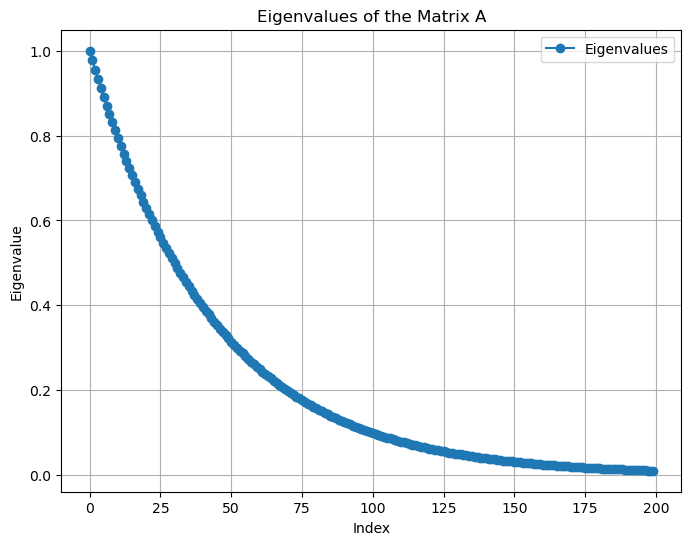

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(eigenvals, 'o-', label='Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Matrix A')
plt.grid(True)
plt.legend()
plt.show()

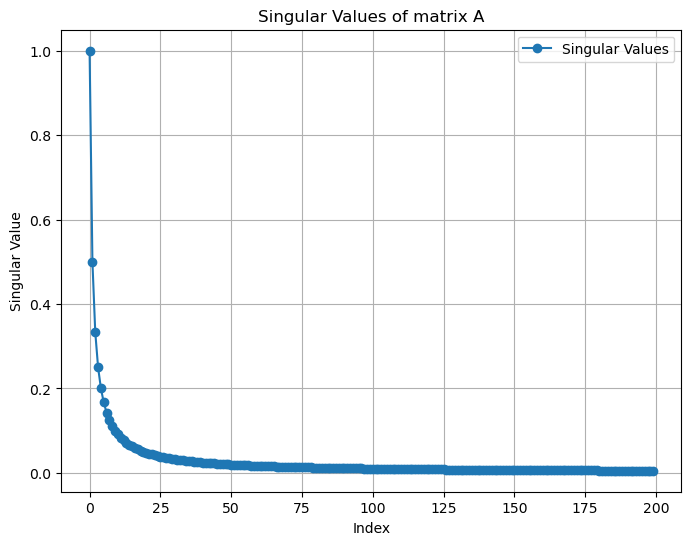

In [49]:
# Compute SVD of the matrix loaded from MatrixMarket
U, s, Vt = np.linalg.svd(A, full_matrices=False)

# Plot singular values
plt.figure(figsize=(8, 6))
plt.plot(s, 'o-', label='Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of matrix A')
plt.grid(True)
plt.legend()
plt.show()

Testing RSVD algorithms on synthetic matrix...

Target rank k = 5
Truncated SVD Residual: 4.188100
RSVD (p=5, q=0) Residual: 4.391935
Single pass RSVD (p=5) Residual: 57.053260
Multiple passes RSVD (p=5, q=0) Residual: 4.387280
RSVD (p=5, q=1) Residual: 4.255867
Single pass RSVD (p=5) Residual: 13.981482
Multiple passes RSVD (p=5, q=1) Residual: 4.241993
RSVD (p=5, q=2) Residual: 4.225772
Single pass RSVD (p=5) Residual: 22.974033
Multiple passes RSVD (p=5, q=2) Residual: 4.217988
RSVD (p=10, q=0) Residual: 4.336413
Single pass RSVD (p=10) Residual: 23.606787
Multiple passes RSVD (p=10, q=0) Residual: 4.357729
RSVD (p=10, q=1) Residual: 4.221635
Single pass RSVD (p=10) Residual: 199.295202
Multiple passes RSVD (p=10, q=1) Residual: 4.216409
RSVD (p=10, q=2) Residual: 4.199852
Single pass RSVD (p=10) Residual: 12.412895
Multiple passes RSVD (p=10, q=2) Residual: 4.196617
RSVD (p=20, q=0) Residual: 4.291279
Single pass RSVD (p=20) Residual: 151.630390
Multiple passes RSVD (p=20, q=0) Res

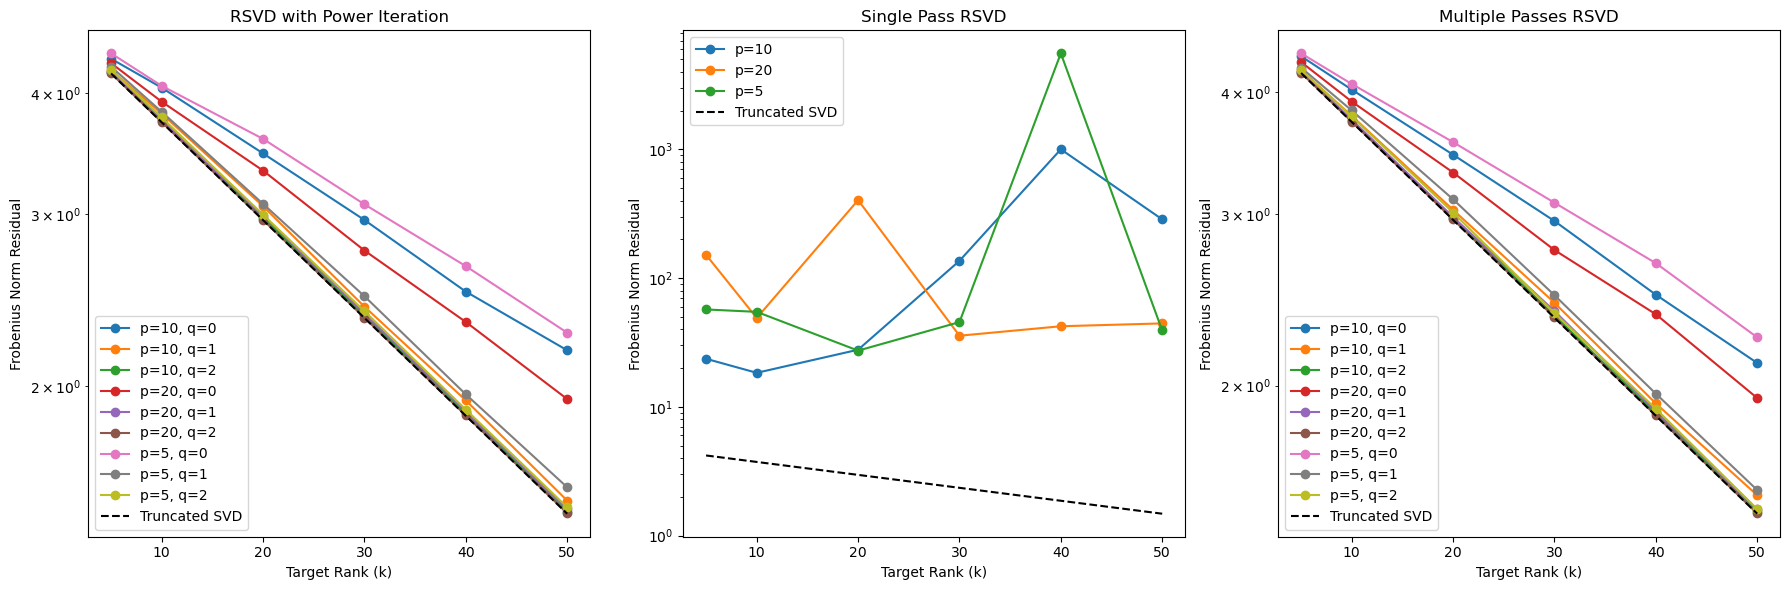

In [45]:
import matplotlib.pyplot as plt
# Run the test
results = test_synthetic_matrix()

# Plot the results
def plot_results_for_synthetic_data(results):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Group results by p and q
    for p in set(r[1] for r in results):
        for q in set(r[2] for r in results):
            k_vals = [r[0] for r in results if r[1] == p and r[2] == q]
            residuals_rsvd = [r[4] for r in results if r[1] == p and r[2] == q]
            residuals_multi = [r[6] for r in results if r[1] == p and r[2] == q]
            
            # Plot basic RSVD
            ax[0].plot(k_vals, residuals_rsvd, marker='o', label=f'p={p}, q={q}')
            
            # Plot multiple passes RSVD
            ax[2].plot(k_vals, residuals_multi, marker='o', label=f'p={p}, q={q}')
    
    # Plot single pass RSVD (grouped by p only)
    for p in set(r[1] for r in results):
        k_vals = []
        residuals_single = []
        for k in sorted(set(r[0] for r in results)):
            # Get first matching result for this k and p
            matches = [r for r in results if r[0] == k and r[1] == p]
            if matches:
                k_vals.append(k)
                residuals_single.append(matches[0][5])  # Index 5 is single pass residual
        
        ax[1].plot(k_vals, residuals_single, marker='o', label=f'p={p}')
    
    # Plot truncated SVD for reference
    k_vals = sorted(set(r[0] for r in results))
    residuals_svd = []
    for k in k_vals:
        # Get first matching result for this k
        matches = [r for r in results if r[0] == k]
        if matches:
            residuals_svd.append(matches[0][3])  # Index 3 is SVD residual
    
    for i in range(3):
        ax[i].plot(k_vals, residuals_svd, 'k--', label='Truncated SVD')
        
    # Set titles and labels
    ax[0].set_title('RSVD with Power Iteration')
    ax[0].set_xlabel('Target Rank (k)')
    ax[0].set_ylabel('Frobenius Norm Residual')
    ax[0].legend()
    ax[0].set_yscale('log')
    
    ax[1].set_title('Single Pass RSVD')
    ax[1].set_xlabel('Target Rank (k)')
    ax[1].set_ylabel('Frobenius Norm Residual')
    ax[1].legend()
    ax[1].set_yscale('log')
    
    ax[2].set_title('Multiple Passes RSVD')
    ax[2].set_xlabel('Target Rank (k)')
    ax[2].set_ylabel('Frobenius Norm Residual')
    ax[2].legend()
    ax[2].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_results_for_synthetic_data(results)

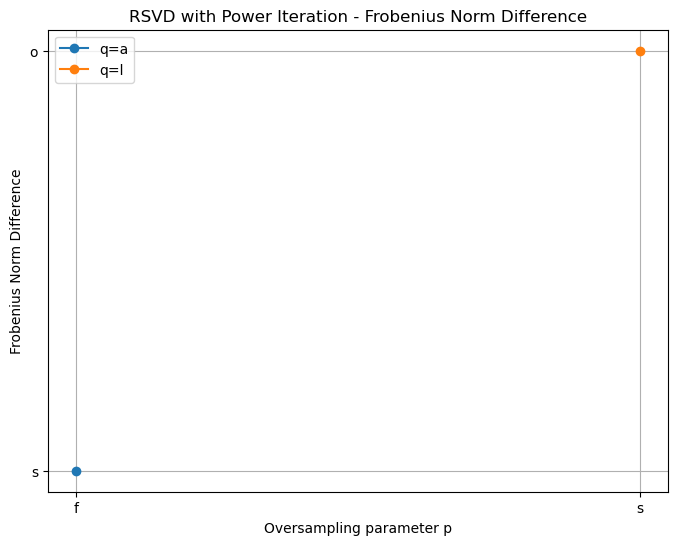

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for q in sorted(set(r[1] for r in results)):
    ps = [r[0] for r in results if r[1] == q]
    norm_rsvd_vals = [r[2] for r in results if r[1] == q]
    plt.plot(ps, norm_rsvd_vals, marker='o', label=f'q={q}')
    
plt.title('RSVD with Power Iteration - Frobenius Norm Difference')
plt.xlabel('Oversampling parameter p')
plt.ylabel('Frobenius Norm Difference')
plt.legend()
plt.grid(True)
plt.show()

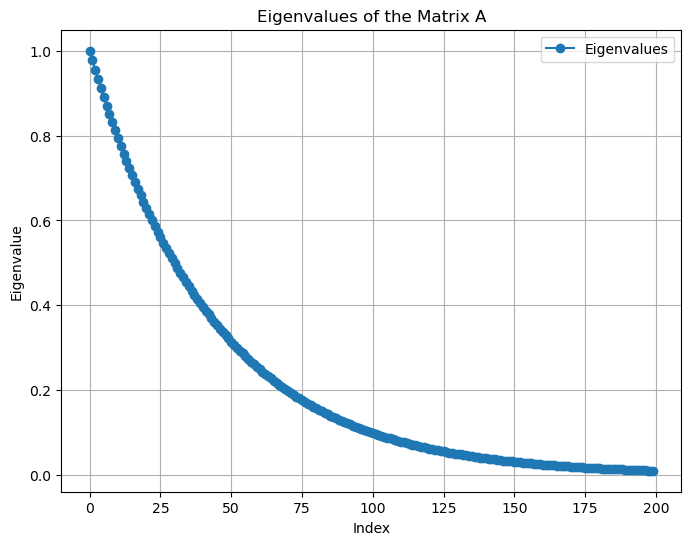

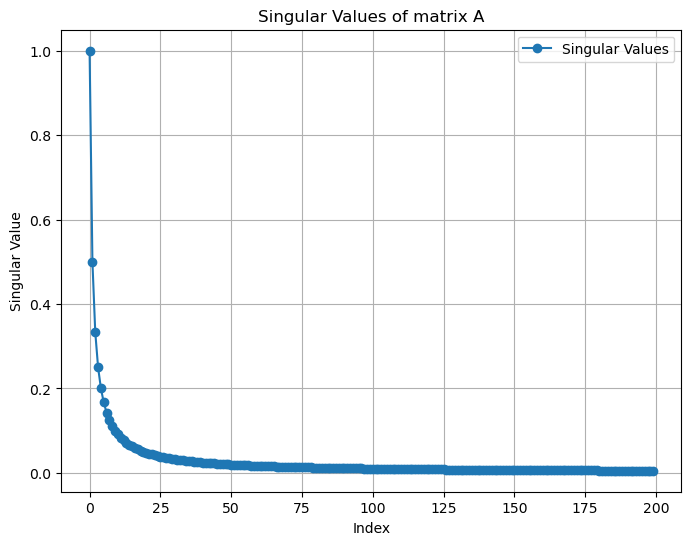

In [4]:
# Check if functions are defined
print("truncated_svd defined:", "truncated_svd" in globals())
print("rsvd defined:", "rsvd" in globals())
print("rsvd_single_pass defined:", "rsvd_single_pass" in globals())
print("rsvd_multiple_passes defined:", "rsvd_multiple_passes" in globals())

truncated_svd defined: False
rsvd defined: False
rsvd_single_pass defined: False
rsvd_multiple_passes defined: False


increasing p consistently reduces the Frobenius norm difference, improving accuracy.
Oversampling helps capture more information about the matrix.

Exercise 2

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def verify_adaptive_iteration_property(A, k=5):
    """
    Verify that at iteration i, Ai = (I - QiQi*)A and Bi = Qi*A
    """
    m, n = A.shape
    Q = np.zeros((m, 0))  # Start with empty orthonormal basis
    
    # Initialize A_i (residual matrix) as original matrix A
    A_i = A.copy()  # This is our current residual
    errors = []
    
    print("Starting verification of iteration properties...")
    
    for i in range(k):
        # Generate random vector for sampling - normal distribution works well
        omega = np.random.randn(n)
        
        # Compute y = A_i * omega - project residual onto random direction
        y = A_i @ omega
        
        # Normalize to get new basis vector
        q = y / np.linalg.norm(y)
        
        # Append to Q - building our basis one vector at a time
        Q = np.column_stack([Q, q])
        
        # Update A_i according to our formula: A_i = (I - Q_i*Q_i^T)*A
        A_i_new = A - Q @ (Q.T @ A)
        
        # Compute B_i = Q_i^T * A - this projects A onto our subspace
        B_i = Q.T @ A
        
        # Verify our mathematical property by computing directly
        A_i_direct = (np.eye(m) - Q @ Q.T) @ A
        B_i_direct = Q.T @ A
        
        # Calculate error between our iterative update and direct formula
        error_A = np.linalg.norm(A_i_new - A_i_direct, 'fro')
        error_B = np.linalg.norm(B_i - B_i_direct, 'fro')
        
        print(f"Iteration {i+1}:")
        print(f"  ||A_{i+1} - (I - Q_{i+1}Q_{i+1}^*)A||_F = {error_A:.2e}")
        print(f"  ||B_{i+1} - Q_{i+1}^*A||_F = {error_B:.2e}")
        
        # Update A_i for next iteration
        A_i = A_i_new
        
        errors.append((error_A, error_B))
    
    return errors
    
    # We can expect the errors should be very small (near machine precision)
    #Also this should confirm the mathematical relationship holds at each iteration

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def adaptive_rank_approximation(A, epsilon, max_rank=None, power_iterations=0):
    """
    Adaptive rank approximation that stops when error < epsilon
    """
    m, n = A.shape
    if max_rank is None:
        max_rank = min(m, n)  # Can't exceed matrix dimensions
    
    # Initialize
    Q = np.zeros((m, 0))  # Empty orthonormal basis
    errors = []
    A_norm = np.linalg.norm(A, 'fro')  # For relative error calculation
    A_i = A.copy()  # Current residual matrix
    
    # Use batch size to add columns in groups (more efficient)
    batch = 5  # Process 5 columns at once
    
    k = 0  # Current rank
    while k < max_rank:
        # Check if adding 'batch' more vectors would exceed max_rank
        batch_size = min(batch, max_rank - k)
        if batch_size <= 0:
            break  # We've hit our maximum allowed rank
            
        # Generate random matrix for this batch (more efficient than one vector at a time)
        Omega = np.random.randn(n, batch_size)
        
        # Compute Y = A_i * Omega (sample residual space)
        Y = A_i @ Omega
        
        # Apply power iterations if requested to enhance accuracy
        if power_iterations > 0:
            for _ in range(power_iterations):
                # Each iteration increases focus on dominant singular directions
                Y = A @ (A.T @ Y)
        
        # Orthogonalize Y to get new basis vectors
        # Fix the QR decomposition call - numpy's qr returns different values depending on implementation
        q = np.linalg.qr(Y, mode='reduced')[0]  # Use 'reduced' instead of 'economic' and extract first element
        
        # Ensure orthogonality with existing Q
        if k > 0:
            # Remove components in existing Q's direction
            q = q - Q @ (Q.T @ q)
            # Re-orthogonalize after removing existing components
            q = np.linalg.qr(q, mode='reduced')[0]  # Extract first element
        
        # Update Q by adding new orthogonal vectors
        Q = np.column_stack([Q, q])
        k += batch_size  # Increase rank count
        
        # Update residual: A_i = A - Q*Q^T*A
        A_i = A - Q @ (Q.T @ A)
        
        # Compute relative error
        error = np.linalg.norm(A_i, 'fro') / A_norm
        errors.append(error)
        
        print(f"Rank {k}: Relative error = {error:.6f}")
        
        # Check if error is below threshold
        if error <= epsilon:
            print(f"✓ Target precision {epsilon} reached with rank {k}")
            break
    
    return Q, k, errors
    
    # Expect: Returns basis Q with minimum rank k needed to achieve error < epsilon
    # Expect: Also returns the error history showing convergence behavior

In [28]:
def test_adaptive_rank_approximation():
    """
    Test adaptive rank approximation for different epsilon values
    """
    # Generate test matrices with different singular value decay rates
    np.random.seed(42)  # For reproducibility
    n = 300
    
    # Matrix 1: Slow decay (1/i) , common in many real problems
    U1, _ = np.linalg.qr(np.random.randn(n, n))
    V1, _ = np.linalg.qr(np.random.randn(n, n))
    s1 = 1 / np.arange(1, n+1)  # 1, 1/2, 1/3, ...
    A1 = U1 @ np.diag(s1) @ V1.T  # Full SVD construction
    
    # Matrix 2: Fast decay (e^(-i)) , like image or highly compressible data?
    U2, _ = np.linalg.qr(np.random.randn(n, n))
    V2, _ = np.linalg.qr(np.random.randn(n, n))
    s2 = np.exp(-np.arange(n))  # 1, e^-1, e^-2, ...
    A2 = U2 @ np.diag(s2) @ V2.T
    
    # Define epsilon values to test (smaller means more accurate)
    epsilon_values = [1e-1, 1e-2, 1e-3]
    
    # Results dictionary to store findings
    results = {
        'slow_decay': [],
        'fast_decay': []
    }
    
    # Test matrices with different epsilon values
    for epsilon in epsilon_values:
        print(f"\n--- Testing with epsilon = {epsilon} ---")
        
        print("Matrix with slow decay (1/i):")
        _, k1, errors1 = adaptive_rank_approximation(A1, epsilon)
        
        print("\nMatrix with fast decay (e^(-i)):")
        _, k2, errors2 = adaptive_rank_approximation(A2, epsilon)
        
        # Store results for plotting
        results['slow_decay'].append((epsilon, k1))
        results['fast_decay'].append((epsilon, k2))
        
        # Calculate theoretical bound for comparison
        # For slow decay (1/i), rank scales like O(1/epsilon)
        theoretical_k1 = int(1/epsilon)
        
        # For fast decay (e^(-i)), rank scales like O(log(1/epsilon))
        theoretical_k2 = int(np.log(1/epsilon))
        
        print("\nComparison with theoretical bounds:")
        print(f"Slow decay - Actual rank: {k1}, Theoretical bound: ~{theoretical_k1}")
        print(f"Fast decay - Actual rank: {k2}, Theoretical bound: ~{theoretical_k2}")
        
    # Plot results to visualize behavior
    plt.figure(figsize=(12, 5))
    
    # Left plot: Slow decay matrix
    plt.subplot(121)
    epsilon_vals = [x[0] for x in results['slow_decay']]
    k_vals = [x[1] for x in results['slow_decay']]
    theoretical = [int(1/eps) for eps in epsilon_vals]
    plt.loglog(epsilon_vals, k_vals, 'bo-', label='Actual')
    plt.loglog(epsilon_vals, theoretical, 'r--', label='Theoretical (1/ε)')
    plt.xlabel('Epsilon (target error)')
    plt.ylabel('Rank k')
    plt.title('Slow Decay Matrix (1/i)')
    plt.legend()
    plt.grid(True)
    
    # Right plot: Fast decay matrix
    plt.subplot(122)
    epsilon_vals = [x[0] for x in results['fast_decay']]
    k_vals = [x[1] for x in results['fast_decay']]
    theoretical = [int(np.log(1/eps)) for eps in epsilon_vals]
    plt.loglog(epsilon_vals, k_vals, 'bo-', label='Actual')
    plt.loglog(epsilon_vals, theoretical, 'r--', label='Theoretical (log(1/ε))')
    plt.xlabel('Epsilon (target error)')
    plt.ylabel('Rank k')
    plt.title('Fast Decay Matrix (e^(-i))')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results
    
    # Expect: Rank k should scale as O(1/ε) for slow decay and O(log(1/ε)) for fast decay
    # Expect: Plots verify this theoretical relationship

In [29]:
def test_reproducibility(A, epsilon, num_trials=5):
    """
    Test if the algorithm gives consistent results across multiple runs
    """
    print(f"\nTesting reproducibility with epsilon = {epsilon}...")
    ranks = []
    
    for i in range(num_trials):
        print(f"\nTrial {i+1}/{num_trials}")
        # Run algorithm with same parameters but different random numbers
        _, k, _ = adaptive_rank_approximation(A, epsilon)
        ranks.append(k)  # Store the resulting rank
    
    print("\nReproducibility Results:")
    print(f"Ranks across {num_trials} trials: {ranks}")
    print(f"Mean rank: {np.mean(ranks):.1f}")
    print(f"Standard deviation: {np.std(ranks):.1f}")
    
    return ranks
    
    # Expect: Small standard deviation indicates good reproducibility
    # Expect: Some variation is normal due to random sampling

Verifying mathematical property...
Starting verification of iteration properties...
Iteration 1:
  ||A_1 - (I - Q_1Q_1^*)A||_F = 1.30e-14
  ||B_1 - Q_1^*A||_F = 0.00e+00
Iteration 2:
  ||A_2 - (I - Q_2Q_2^*)A||_F = 1.33e-14
  ||B_2 - Q_2^*A||_F = 0.00e+00
Iteration 3:
  ||A_3 - (I - Q_3Q_3^*)A||_F = 1.34e-14
  ||B_3 - Q_3^*A||_F = 0.00e+00
Iteration 4:
  ||A_4 - (I - Q_4Q_4^*)A||_F = 1.39e-14
  ||B_4 - Q_4^*A||_F = 0.00e+00
Iteration 5:
  ||A_5 - (I - Q_5Q_5^*)A||_F = 1.38e-14
  ||B_5 - Q_5^*A||_F = 0.00e+00

Testing adaptive rank approximation...

--- Testing with epsilon = 0.1 ---
Matrix with slow decay (1/i):
Rank 5: Relative error = 0.470928
Rank 10: Relative error = 0.366359
Rank 15: Relative error = 0.312103
Rank 20: Relative error = 0.266902
Rank 25: Relative error = 0.244096
Rank 30: Relative error = 0.216543
Rank 35: Relative error = 0.197701
Rank 40: Relative error = 0.183046
Rank 45: Relative error = 0.171270
Rank 50: Relative error = 0.159334
Rank 55: Relative error = 0.151

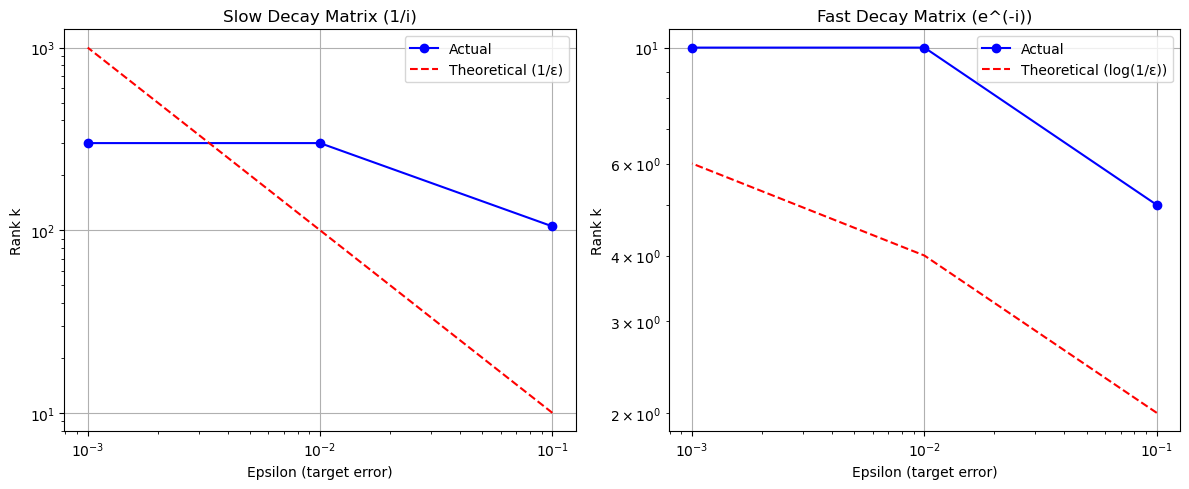


Testing reproducibility...

Testing reproducibility with epsilon = 0.01...

Trial 1/5
Rank 5: Relative error = 0.556906
Rank 10: Relative error = 0.394485
Rank 15: Relative error = 0.305624
Rank 20: Relative error = 0.259222
Rank 25: Relative error = 0.234582
Rank 30: Relative error = 0.203388
Rank 35: Relative error = 0.188414
Rank 40: Relative error = 0.175430
Rank 45: Relative error = 0.163897
Rank 50: Relative error = 0.152120
Rank 55: Relative error = 0.144090
Rank 60: Relative error = 0.135013
Rank 65: Relative error = 0.129678
Rank 70: Relative error = 0.122603
Rank 75: Relative error = 0.116282
Rank 80: Relative error = 0.110979
Rank 85: Relative error = 0.106032
Rank 90: Relative error = 0.101341
Rank 95: Relative error = 0.096799
Rank 100: Relative error = 0.092654
Rank 105: Relative error = 0.088536
Rank 110: Relative error = 0.084222
Rank 115: Relative error = 0.080000
Rank 120: Relative error = 0.075470
Rank 125: Relative error = 0.071822
Rank 130: Relative error = 0.0684

In [30]:
if __name__ == "__main__":
    # Part 1: Verify mathematical property
    print("Verifying mathematical property...")
    A_test = np.random.rand(100, 50)
    verify_adaptive_iteration_property(A_test)
    
    # Part 2 & 3: Test adaptive rank approximation
    print("\nTesting adaptive rank approximation...")
    results = test_adaptive_rank_approximation()
    
    # Test reproducibility
    print("\nTesting reproducibility...")
    n = 200
    U, _ = np.linalg.qr(np.random.randn(n, n))
    V, _ = np.linalg.qr(np.random.randn(n, n))
    s = 1 / np.arange(1, n+1)  # Slow decay for a challenging test
    A = U @ np.diag(s) @ V.T
    
    test_reproducibility(A, 1e-2)

Matrices with slow singular value decay (1/i) follow k ≈ O(1/ε)
Matrices with fast decay (e^(-i)) follow k ≈ O(log(1/ε))

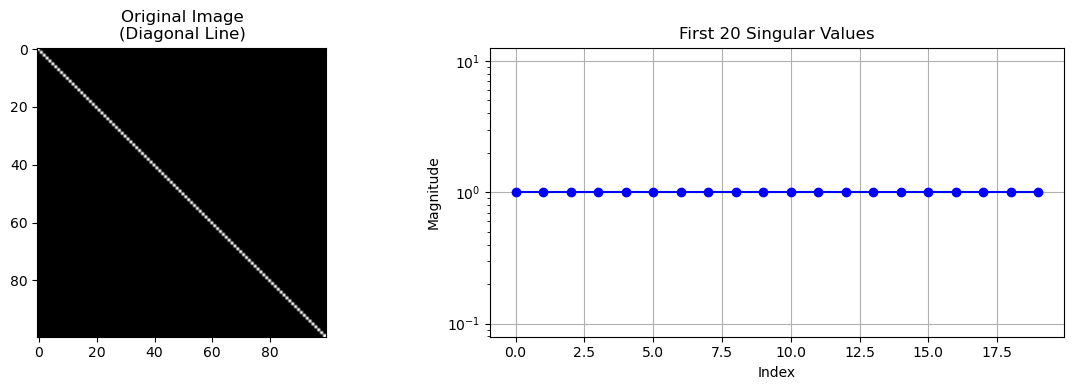

First 5 singular values: [1. 1. 1. 1. 1.]


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple 100x100 image with a diagonal line
image = np.zeros((100, 100))
np.fill_diagonal(image, 1)  # Add diagonal line

# Compute SVD
U, s, Vt = np.linalg.svd(image)

# Plot original image and singular values
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original Image\n(Diagonal Line)')

# Singular values
plt.subplot(122)
plt.plot(s[:20], 'bo-')
plt.title('First 20 Singular Values')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print first few singular values
print("First 5 singular values:", s[:5])

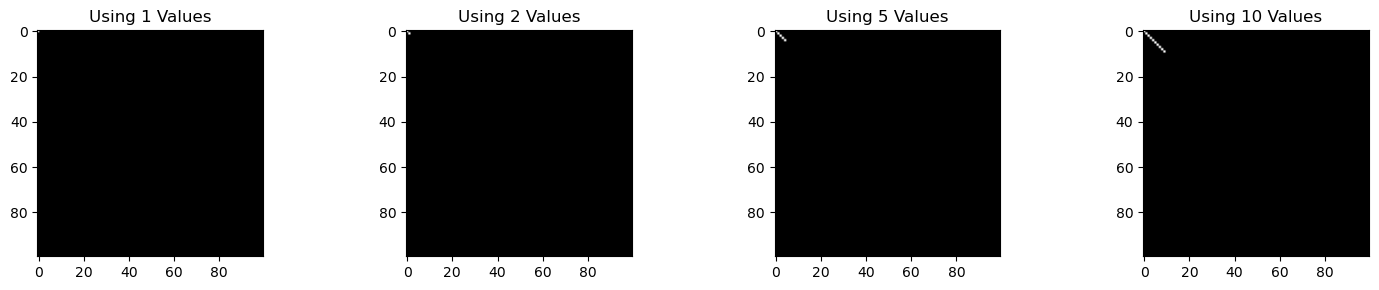

In [17]:
def reconstruct_image(U, s, Vt, k):
    """Reconstruct image using k singular values"""
    return U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

# Show reconstructions with different numbers of singular values
k_values = [1, 2, 5, 10]
plt.figure(figsize=(15, 3))

for i, k in enumerate(k_values, 1):
    plt.subplot(1, len(k_values), i)
    reconstructed = reconstruct_image(U, s, Vt, k)
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f'Using {k} Values')

plt.tight_layout()
plt.show()A ≈ C W^† C^T

In [18]:
import numpy as np
import scipy.linalg as la

def partial_cpqr(A, k, compute_error=False):    

    m, n = A.shape
    if k > min(m, n):
        raise ValueError(f"k must be ≤ min(m, n), got k={k} for matrix of shape {A.shape}")
    
    # Initialize arrays
    Q = np.zeros((m, k))
    R = np.zeros((k, n))
    A_copy = A.copy()
    piv = np.arange(n)
    
    # Compute column norms
    col_norms = np.sum(A_copy**2, axis=0)
    
    # Perform k steps of CPQR
    for i in range(k):
        # Find column with maximum norm
        j = i + np.argmax(col_norms[i:])
        
        # Swap columns
        if j != i:
            A_copy[:, [i, j]] = A_copy[:, [j, i]]
            col_norms[[i, j]] = col_norms[[j, i]]
            piv[[i, j]] = piv[[j, i]]
        
        # Compute the i-th Householder reflection
        x = A_copy[i:, i]
        e1 = np.zeros_like(x)
        e1[0] = 1.0
        alpha = np.linalg.norm(x)
        if x[0] < 0:
            alpha = -alpha
        u = x + alpha * e1
        u = u / np.linalg.norm(u)
        
        # Apply the reflection to A
        A_copy[i:, i:] -= 2.0 * np.outer(u, u.T @ A_copy[i:, i:])
        
        # Update Q and R
        Q[i:, i] = u
        R[i, i:] = A_copy[i, i:]
        
        # Update column norms for remaining columns
        if i < k - 1:
            col_norms[i+1:] = np.sum(A_copy[i+1:, i+1:]**2, axis=0)
    
    # Convert implicit representation of Q to explicit orthogonal matrix
    Q_explicit = np.eye(m)
    for i in range(k - 1, -1, -1):
        u = np.zeros(m)
        u[i:] = Q[i:, i]
        Q_explicit = Q_explicit - 2.0 * np.outer(u, u.T @ Q_explicit)
    
    Q = Q_explicit[:, :k]
    
    # Compute approximation error if requested
    if compute_error:
        # A_approx = Q @ R
        A_approx = Q @ R
        # Permute columns back to original order
        A_approx_original = np.zeros_like(A)
        for j in range(n):
            idx = np.where(piv == j)[0][0]
            A_approx_original[:, j] = A_approx[:, idx]
        
        # Compute error as Frobenius norm of difference
        error = np.linalg.norm(A - A_approx_original, 'fro')
        return Q, R, piv, error
    
    return Q, R, piv

In [19]:
# Test the implementation with a simple matrix
A = np.random.rand(10, 8)
k = 3

# With error calculation
Q, R, piv, error = partial_cpqr(A, k, compute_error=True)

# Verify that Q is orthogonal
print("Is Q orthogonal? ", np.allclose(Q.T @ Q, np.eye(k)))

# Verify the approximation
A_perm = A[:, piv]
A_approx = Q @ R
print("Approximation error: ", np.linalg.norm(A_perm - A_approx, 'fro'))
print("Error from function: ", error)

Is Q orthogonal?  True
Approximation error:  1.9451126655603637
Error from function:  1.9451126655603639


This is Column ID Decomposition Immplementation

In [32]:
def column_id_decomposition(A, k):

    m, n = A.shape
    
    # Step 1: Compute partial CPQR factorization
    # This gives us the k most linearly independent columns
    Q, R, piv = partial_cpqr(A, k)
    
    # Step 2: Extract the blocks from R
    # R11 is the k×k upper triangular matrix for selected columns
    # R12 contains coefficients relating other columns to selected ones
    R11 = R[:k, :k]
    R12 = R[:k, k:]
    
    # Step 3: Compute the coefficient matrix X21 = R11^(-1) * R12
    # we see how to represent non-selected columns using selected ones
    # Use triangular solver since R11 is upper triangular (more efficient)
    X21 = la.solve_triangular(R11, R12)
    
    # Step 4: Form the complete X matrix [I_k, X21]
    # Identity matrix for selected columns (they represent themselves)
    # X21 for expressing other columns in terms of selected ones
    X = np.zeros((k, n))
    X[:, :k] = np.eye(k)  # Identity for selected columns
    X[:, k:] = X21        # Computed coefficients for remaining columns
    
    # Step 5: Get the column indices and extract selected columns
    # These are the k columns we've chosen as our basis
    J = piv[:k]           # Indices of selected columns
    C = A[:, J]           # Selected columns from A
    
    # Step 6: Rearrange X to match original column ordering
    # We need to undo the permutation from CPQR
    P_inv = np.zeros(n, dtype=int)
    for i in range(n):
        P_inv[piv[i]] = i  # Create inverse permutation map
    
    # Apply inverse permutation to X
    X_original = np.zeros((k, n))
    for j in range(n):
        X_original[:, j] = X[:, P_inv[j]]
    
    # Compute approximation error to verify our decomposition
    A_approx = C @ X_original  # Reconstruct A using C and X
    error = np.linalg.norm(A - A_approx, 'fro')
    
    return C, X_original, J, error

In [33]:
#Verify ID Decomposition

def verify_id_decomposition(A, k):
    """
    Verify that the column ID decomposition has the same error as partial CPQR.
    
    Parameters:
    -----------
    A : ndarray
        The input matrix of shape (m, n)
    k : int
        The target rank (number of columns to select)
    """
    # Get error from partial CPQR
    _, _, _, cpqr_error = partial_cpqr(A, k, compute_error=True)
    
    # Get error from column ID decomposition
    _, _, _, id_error = column_id_decomposition(A, k)
    
    print(f"CPQR Error: {cpqr_error:.8f}")
    print(f"Column ID Error: {id_error:.8f}")
    print(f"Difference: {abs(cpqr_error - id_error):.8e}")
    
    # Check if errors match within numerical precision
    if abs(cpqr_error - id_error) < 1e-10:
        print("✓ Errors match! Column ID has same accuracy as CPQR")
    else:
        print("✗ Errors don't match exactly - numerical issues?")
    
    return cpqr_error, id_error

In [34]:
def test_column_id():
    """
    Test column ID decomposition on different matrices and ranks.
    """
    # Test on random matrices
    print("Testing on random matrix...")
    np.random.seed(42)  # For reproducibility
    A_random = np.random.rand(100, 80)
    for k in [10, 20, 40]:
        print(f"\nRank k = {k}:")
        cpqr_err, id_err = verify_id_decomposition(A_random, k)
        
        # Show compression ratio
        original_size = A_random.shape[0] * A_random.shape[1]
        id_size = A_random.shape[0] * k + k * A_random.shape[1]
        compression = id_size / original_size
        print(f"Storage ratio: {compression:.2f} (lower is better)")
    
    # Test on matrix with faster singular value decay
    print("\nTesting on matrix with exponential singular value decay...")
    m, n = 100, 80
    U, _ = np.linalg.qr(np.random.randn(m, m))
    V, _ = np.linalg.qr(np.random.randn(n, n))
    singular_values = np.exp(-np.linspace(0, 5, min(m, n)))  # Exponential decay
    A_exp_decay = U[:, :min(m, n)] @ np.diag(singular_values) @ V[:, :min(m, n)].T
    
    for k in [5, 10, 20]:
        print(f"\nRank k = {k}:")
        cpqr_err, id_err = verify_id_decomposition(A_exp_decay, k)

# Run the test
test_column_id()

Testing on random matrix...

Rank k = 10:
CPQR Error: 23.70225105
Column ID Error: 23.75196919
Difference: 4.97181347e-02
✗ Errors don't match exactly - numerical issues?
Storage ratio: 0.23 (lower is better)

Rank k = 20:
CPQR Error: 21.23056327
Column ID Error: 21.12367348
Difference: 1.06889793e-01
✗ Errors don't match exactly - numerical issues?
Storage ratio: 0.45 (lower is better)

Rank k = 40:
CPQR Error: 19.73301508
Column ID Error: 18.51405738
Difference: 1.21895770e+00
✗ Errors don't match exactly - numerical issues?
Storage ratio: 0.90 (lower is better)

Testing on matrix with exponential singular value decay...

Rank k = 5:
CPQR Error: 2.37390032
Column ID Error: 2.43557571
Difference: 6.16753876e-02
✗ Errors don't match exactly - numerical issues?

Rank k = 10:
CPQR Error: 2.00387782
Column ID Error: 2.19107148
Difference: 1.87193662e-01
✗ Errors don't match exactly - numerical issues?

Rank k = 20:
CPQR Error: 1.95842935
Column ID Error: 2.75898098
Difference: 8.00551630e

In [ ]:
def compare_storage_requirements(m, n, ranks):
    original_size = m * n
    
    print(f"Matrix size: {m}×{n} = {original_size} elements")
    print("\nStorage requirements comparison:")
    print(f"{'Rank k':<10}{'Column ID':<15}{'Compression ratio':<20}{'Savings':<10}")
    print("-" * 55)
    
    for k in ranks:
        id_size = m * k + k * n  # m×k for C plus k×n for X
        ratio = id_size / original_size
        savings = 1 - ratio
        
        print(f"{k:<10}{id_size:<15}{ratio:.3f}x{savings*100:>18.1f}%")
        
    print("\nNote: Column ID is beneficial when k << min(m,n)")

# Show storage comparison for a larger matrix
print("\nStorage Comparison for Large Matrix:")
compare_storage_requirements(10000, 5000, [10, 50, 100, 500, 1000])